# The Structural Relationship of Childcare Expenses and Workforce Attachment
## Jesús Pacheco & Dave Foote

In [1]:
#imports
import numpy as np
import pandas as pd
import scipy.stats as sts
import math
from matplotlib import pyplot as plt
import requests
import scipy.optimize as opt
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
import structural_childcare as sc
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#read data
df = pd.read_csv('../rdf_subset.csv')
df['intercept'] = 1
state_map = {1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas',
            6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware',
            11: 'D.C.', 12: 'Florida', 13: 'Georgia', 15: 'Hawaii',
            16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa',
            20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana', 23: 'Maine',
            24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan',
            27: 'Minnesota', 28: 'Mississippi', 29: 'Missouri', 30: 'Montana',
            31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire',
            34: 'New Jersey', 35: 'New Mexico', 36: 'New York',
            37: 'North Carolina', 38: 'North Datoka', 39: 'Ohio',
            40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania',
            44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota',
            47: 'Tennessee', 48: 'Texas', 49: 'Utah', 50: 'Vermont',
            51: 'Virginia', 53: 'Washington', 54: 'West Virginia',
            55: 'Wisconsin', 56: 'Wyoming', 60: 'Puerto Rico and Island Areas',
            61: 'Foreign Country'}
bls_data = pd.read_csv('../bls_data.csv')

In [3]:
df['monthly_job_hours'] = df['monthly_job_hrs'] * 4
#one respondant works .25 hours a week and is messing this up:
df.loc[df['monthly_job_hours'] == 1, 'monthly_job_hours'] = .9999

In [4]:
bls_data.State_number = bls_data.State_number.map(state_map)
bls_data.head()

,State_number,STATE_CC_COST,STATE_MEDIAN_WAGE
0,Alabama,9.02,16.22
1,Alaska,12.95,23.09
2,Arizona,11.51,17.80
3,Arkansas,9.44,15.31
4,California,12.67,20.40


In [5]:
state_cc_map = {}
state_medwage_map = {}
for i, r in bls_data.iterrows():
    state_cc_map[r['State_number']] = r['STATE_CC_COST']
    state_medwage_map[r['State_number']] = r['STATE_MEDIAN_WAGE']

In [6]:
df['STATE'] = df.State_number.map(state_map)
df['STATE_CC_COST'] = df.STATE.map(state_cc_map)
df['STATE_MEDIAN_WAGE'] = df.STATE.map(state_medwage_map)

In [7]:
#our functions:
def mle_beta_vec(df, xcols, init_guess, target_col, f):
    '''
    df = dataframe
    xcolumn names in list form
    init_guess in tuple form
    criterion function f
    doin the damn thing (write better comment later)
    '''
    x_mat = extract_x_matrix(df, xcols)
    y_vec = df[target_col]
    
    results_uncstr = opt.minimize(f, init_guess, method = 'L-BFGS-B', args=(x_mat, y_vec))
    VCV = results_uncstr.hess_inv.todense()
    error_info = get_st_error(xcols, VCV)

    return results_uncstr, VCV

def criterion(beta_guess, *args):
    '''
    beta_guess comes in as array
    '''
    x_mat, y_vec = args
    
    
    
    return logit_neglog_likelihood(beta_guess, y_vec, x_mat, prob_1)

def logit_neglog_likelihood(beta_vec, *args):
    '''
    calculate the log likelihood that the probability is correct
    '''
    y_vec, xm, probability_now = args
    p = list(probability_now(xm, beta_vec))
    y_vec = list(y_vec)
    rv = []
    for i, x in enumerate(p):
        to_add = ((y_vec[i] * math.log(x))) + ((1 - y_vec[i]) * math.log(1 - x))
        if to_add is not np.nan:
            rv.append(to_add)
    rv = pd.Series(rv)

    return -(rv.sum())

def prob_1(x_matrix, beta_vec):
    '''
    calculate probability a set of observations is a member of d1, using logit
    classification
    '''
    linear_kernel = x_matrix.dot(beta_vec)
    rv = np.exp(linear_kernel) / (1 + np.exp(linear_kernel))
    rv[rv == 1] = .999999
    rv[rv == 0] = 1e-11

    return rv

def categorical_split(df):
    cond1 = (df['monthly_childcare_expenditure'] == 0)
    cond2 = (df['monthly_childcare_expenditure'] > 0)
    cond3 = (df['monthly_wage'] > 0)
    cond4 = (df['monthly_wage'] == 0)

    return df[cond1 & cond3], df[cond2 & cond3], df[cond4]

def extract_x_matrix(df, xcols):
    '''
    inputs: df with data and column names of your x variables
    output: n x k matrix of x data where n is #observations and k is
    #of columns
    '''
    
    return df[xcols].to_numpy()

def categorize_ds(df):
    '''
    input: df with H and F calculated columns
    output: same df with d1-4 columns denoting membership in groups d1, d2,
    d3, and d4 defined as such:
    d1 - H = 0, F = 0
    d2 - H = 0, F = 1
    d3 - H = 1, F = 0
    d4 - H = 1, F = 1
    '''

    df['d1'] = [1 if (r['H'] == 0) & (r['F'] == 0) else 0 for i, r in df.iterrows()]
    df['d2'] = [1 if (r['H'] == 0) & (r['F'] == 1) else 0 for i, r in df.iterrows()]
    df['d3'] = [1 if (r['H'] == 1) & (r['F'] == 0) else 0 for i, r in df.iterrows()]
    df['d4'] = [1 if (r['H'] == 1) & (r['F'] == 1) else 0 for i, r in df.iterrows()]
    
def get_st_error(col_names, VCV):
    '''
    given the order of the regressors and the variance covariance matrix from 
    the minimization, this function will return a dictionary mapping variable names
    to their standard erros, as well as print this information
    '''
    rd = {}
    for i, x in enumerate(col_names):
        rd[x] = np.sqrt(VCV[i, i])
        print("error for {}: ".format(x), rd[x])

    return rd

# So begins our estimation...
We use categorize_ds to estimate membership in our d groups such that:  
    d1 - H = 0, F = 0  
    d2 - H = 0, F = 1  
    d3 - H = 1, F = 0  
    d4 - H = 1, F = 1  

In [8]:
categorize_ds(df)
est_cols = ['intercept', 'k_under2', 'k_3to5', 'education', 'reg_ratio',
           'monthly_job_hours', 'STATE_CC_COST', 'STATE_MEDIAN_WAGE']
generalized_guess = (.05, .05, .05, .05, .05, .05, .05, .05)

In [9]:
df[df.monthly_job_hours == .9999]

,Unnamed: 0,ssuid,monthly_childcare_expenditure,k_under2,k_3to5,k_6to10,METRO,reg_ratio,criminal_records,daycare_regulations,...,F,intercept,monthly_job_hours,STATE,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4
1108,1109,3.324063e+11,0.0,1.0,0.0,0.0,1.0,10.0,1.0,1.0,...,0,1,0.9999,North Carolina,10.35,17.19,1,0,0,0


In [10]:
results1, errors1 = mle_beta_vec(df, est_cols, generalized_guess, 'd1', criterion)

error for intercept:  64.93196421563994
error for k_under2:  10.661908621122759
error for k_3to5:  0.7949028637718805
error for education:  1.6107810108631393
error for reg_ratio:  2.4079482791630835
error for monthly_job_hours:  0.04411593767263908
error for STATE_CC_COST:  10.74422024191187
error for STATE_MEDIAN_WAGE:  7.724107028753337


In [11]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results1.x[i])

Beta Estimate for intercept : 6.230064906138512
Beta Estimate for k_under2 : 0.21331860039872652
Beta Estimate for k_3to5 : -0.4656634504526347
Beta Estimate for education : -0.13603443694521095
Beta Estimate for reg_ratio : -0.04637165686470501
Beta Estimate for monthly_job_hours : -0.0437388942315292
Beta Estimate for STATE_CC_COST : -0.06282497795996204
Beta Estimate for STATE_MEDIAN_WAGE : -0.051147192328088766


In [12]:
results2, errors2 = mle_beta_vec(df, est_cols, generalized_guess, 'd2', criterion)

error for intercept:  29.90348828271949
error for k_under2:  2.2550547146305675
error for k_3to5:  7.7039764648661055
error for education:  1.351236001675222
error for reg_ratio:  1.8000717538169293
error for monthly_job_hours:  0.06690531870743437
error for STATE_CC_COST:  0.9507038735524167
error for STATE_MEDIAN_WAGE:  1.2323205266295867


In [13]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results2.x[i])

Beta Estimate for intercept : -4.544336685523973
Beta Estimate for k_under2 : -0.1915252291248931
Beta Estimate for k_3to5 : 0.4866002138042188
Beta Estimate for education : 0.1584535381050981
Beta Estimate for reg_ratio : -0.0034668244149025345
Beta Estimate for monthly_job_hours : -0.01684088346851691
Beta Estimate for STATE_CC_COST : -0.05384211876511244
Beta Estimate for STATE_MEDIAN_WAGE : 0.07335954907669937


In [14]:
results3, errors3 = mle_beta_vec(df, est_cols, generalized_guess, 'd3', criterion)

error for intercept:  134.32106793928526
error for k_under2:  3.9927724742921082
error for k_3to5:  4.477355776825626
error for education:  2.4818253900623914
error for reg_ratio:  8.27195231762596
error for monthly_job_hours:  0.3820204438428794
error for STATE_CC_COST:  17.65219464157781
error for STATE_MEDIAN_WAGE:  8.117436959350378


In [15]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results3.x[i])

Beta Estimate for intercept : -1.6973830310774172
Beta Estimate for k_under2 : -0.27348969276867785
Beta Estimate for k_3to5 : -0.5621267716136666
Beta Estimate for education : -0.1266662337673093
Beta Estimate for reg_ratio : 0.04302659514265575
Beta Estimate for monthly_job_hours : 0.023105379035521553
Beta Estimate for STATE_CC_COST : 0.0909717250996231
Beta Estimate for STATE_MEDIAN_WAGE : -0.060384608375909685


In [16]:
results4, errors4 = mle_beta_vec(df, est_cols, generalized_guess, 'd4', criterion)

error for intercept:  284.46060215383375
error for k_under2:  3.1651438759694757
error for k_3to5:  29.556033295612362
error for education:  1.2699707609529347
error for reg_ratio:  6.453149970922487
error for monthly_job_hours:  0.4604829944253569
error for STATE_CC_COST:  25.025185657006872
error for STATE_MEDIAN_WAGE:  29.5640901243362


In [17]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results4.x[i])

Beta Estimate for intercept : -5.525476070413992
Beta Estimate for k_under2 : 0.25975463065297216
Beta Estimate for k_3to5 : 0.5742335349421527
Beta Estimate for education : 0.0960009944542783
Beta Estimate for reg_ratio : -0.023425005027653507
Beta Estimate for monthly_job_hours : 0.022035587557862953
Beta Estimate for STATE_CC_COST : -0.05673592523657938
Beta Estimate for STATE_MEDIAN_WAGE : 0.050114123529715345


# EXPLORATORY DATA ANALYSIS:

In [18]:
df.head()

,Unnamed: 0,ssuid,monthly_childcare_expenditure,k_under2,k_3to5,k_6to10,METRO,reg_ratio,criminal_records,daycare_regulations,...,F,intercept,monthly_job_hours,STATE,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4
0,1,114285765.0,0.0,0.0,1.0,0.0,1.0,7.0,1.0,1.0,...,0,1,0.000000,Kansas,9.36,17.28,1,0,0,0
1,2,114552343.0,0.0,0.0,1.0,2.0,1.0,7.0,1.0,1.0,...,0,1,104.166667,Kansas,9.36,17.28,0,0,1,0
2,3,114552369.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,1.0,...,0,1,127.483333,Kansas,9.36,17.28,0,0,1,0
3,4,418037420.0,0.0,1.0,2.0,0.0,1.0,7.0,1.0,1.0,...,0,1,0.000000,Minnesota,11.61,20.49,1,0,0,0
4,5,418086894.0,0.0,0.0,0.0,2.0,0.0,8.0,1.0,1.0,...,0,1,104.833333,Oklahoma,9.27,16.62,0,0,1,0


In [19]:
dave_palette = ["#004067", "#BF4848", "#BA69E0", "#00B14A"]
sns.set(rc={'axes.facecolor':"white", 'font.fantasy':'Chicago', 'axes.edgecolor':'black', 'axes.linewidth':'2',
           'text.color':'black', 'axes.labelcolor':'black', 'ytick.color':'black', 'xtick.color':'black'})

In [20]:
df['category'] = df[['d1', 'd2', 'd3', 'd4']].idxmax(axis=1)

In [37]:
df.monthly_childcare_expenditure = [x if x!= 0 else .0001 for x in df.monthly_childcare_expenditure]
df.monthly_childcare_expenditure = [x if x!= .9999 else 1 for x in df.monthly_childcare_expenditure]
df['log_exp'] = [math.log(x) for x in df.monthly_childcare_expenditure]

Text(0.5, 1.0, 'Our Categorizations (and the censors they are bounded by)')

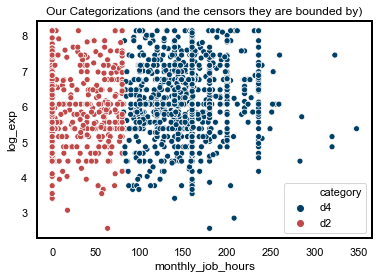

In [38]:
sns.scatterplot(x='monthly_job_hours', y='log_exp', hue='category', palette=dave_palette[:2],
               data=df.loc[df.log_exp > 0]).set_title("Our Categorizations (and the censors they are bounded by)")

Text(0.5, 1.0, "Working Mothers' Childcare Usage Not Determined By Hours")

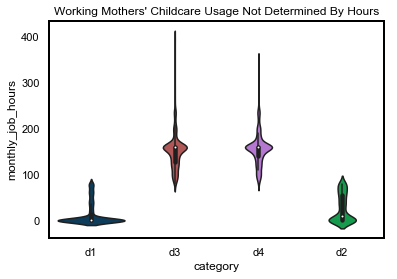

In [22]:
sns.violinplot(x='category', y='monthly_job_hours', palette=dave_palette,
            data=df).set_title("Working Mothers' Childcare Usage Not Determined By Hours")

In [23]:
df['has_kunder2'] = df.k_under2.apply(lambda x: True if x > 0 else False)

Text(0.5, 1.0, 'Having Children Under 2 Affects Working Women Differently')

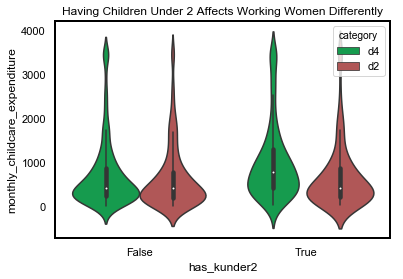

In [24]:
sns.violinplot(x='has_kunder2', y='monthly_childcare_expenditure', hue='category',
            palette=[dave_palette[3], dave_palette[1]], data=df[df.category.isin(['d2','d4'])]).set_title("Having Children Under 2 Affects Working Women Differently")

Text(0.5, 1.0, 'Wage vs Hours Across Categories')

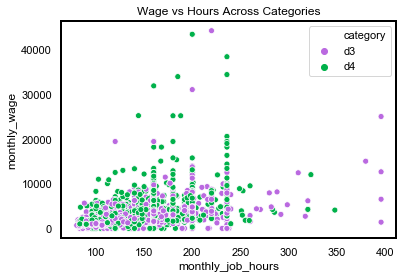

In [25]:
sns.scatterplot(x='monthly_job_hours', y='monthly_wage', hue='category',
            palette=[dave_palette[2], dave_palette[3]], data=df[df.category.isin(['d3', 'd4'])]).set_title("Wage vs Hours Across Categories")

Text(0.5, 0.98, 'Comparing Hours and Wage as Indicators Among Working Mothers')

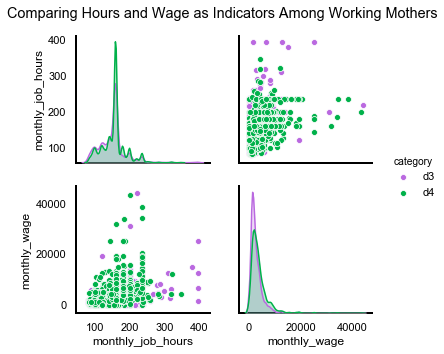

In [ ]:
g = sns.pairplot(df[df.category.isin(['d3', 'd4'])][['category', 'monthly_job_hours', 'monthly_wage']],
             hue="category", palette=[dave_palette[2], dave_palette[3]])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Comparing Hours and Wage as Indicators Among Working Mothers')

In [ ]:
df['binned_expenditure'] = pd.cut(list(df.monthly_childcare_expenditure), 5, labels=['low', 'med-low','med', 
                                                                           'med-high', 'high'])
df['payrate'] = df.monthly_wage / df.monthly_job_hours

In [ ]:
df['binned_education'] = pd.cut(list(df.education), [0, 8, 12, 14, 16, 18, 100], labels=['Under 8th Grade',
                                                                            'Attended But did not Complete HS',
                                                                            'HS Graduates', 'College Exp',
                                                                            'Graduated College', 'Advanced Degree'])

In [ ]:
df[df.category == 'd4'].shape

(1361, 35)

Text(0.5, 1.0, "Income Distribution Differences Between Working Mothers Who Do and Don't Utilize Childcare")

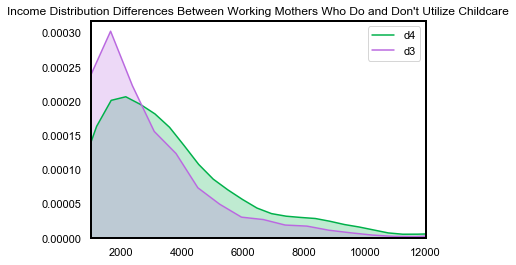

In [ ]:
ax = sns.kdeplot(df[df.category == 'd4'].monthly_earned_income, color=dave_palette[3],
                 shade=True, legend=False)
sns.kdeplot(df[df.category == 'd3'].monthly_earned_income, ax=ax, color=dave_palette[2],
            shade=True, legend=False)
plt.xlim(1000, 12000)

plt.legend(labels=['d4', 'd3'])
plt.title("Income Distribution Differences Between Working Mothers Who Do and Don't Utilize Childcare")

In [ ]:
df[df.monthly_childcare_expenditure < 0].shape

(0, 35)

Text(0.5, 1.0, 'Childcare Costs Distributed Similarly for Working and Non-Working Utilizers')

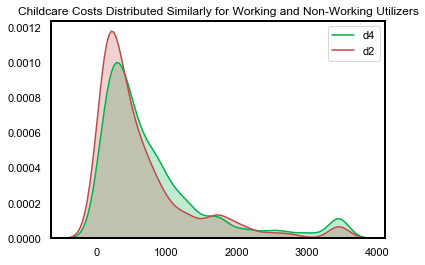

In [ ]:
ax = sns.kdeplot(df[df.category == 'd4'].monthly_childcare_expenditure, color=dave_palette[3],
                 shade=True, legend=False)
sns.kdeplot(df[df.category == 'd2'].monthly_childcare_expenditure, ax=ax, color=dave_palette[1],
            shade=True, legend=False)

plt.legend(labels=['d4', 'd2'])
plt.title("Childcare Costs Distributed Similarly for Working and Non-Working Utilizers")

In [ ]:
df['k_under5'] = df['k_under2'] + df['k_3to5']

Text(0.5, 1.0, "Kids Under 5 Distributed Similarly Between Women Who Do and Don't Utilize Childcare")

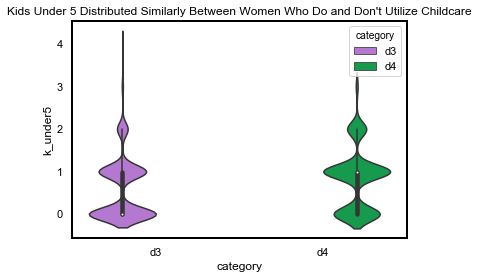

In [ ]:
sns.violinplot(x='category', y='k_under5', hue='category',
           data=df[df.category.isin(['d3', 'd4'])], palette=[dave_palette[2], dave_palette[3]],
              ).set_title("Kids Under 5 Distributed Similarly Between Women Who Do and Don't Utilize Childcare")


Text(0.5, 1.0, 'Those Staying Home Had More Young Children')

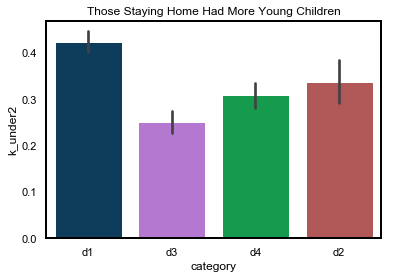

In [ ]:
sns.barplot(x='category', y='k_under2', palette=[dave_palette[0], dave_palette[2], dave_palette[3],
                                                dave_palette[1]],
            data=df).set_title("Those Staying Home Had More Young Children")

Text(0.5, 1.0, 'Education Differences Between Categories')

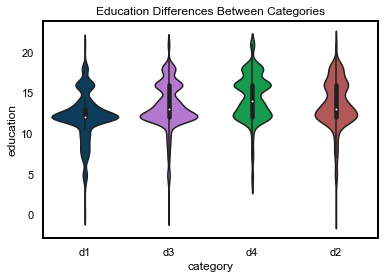

In [ ]:
sns.violinplot(x='category', y='education', palette=[dave_palette[0], dave_palette[2], dave_palette[3],dave_palette[1]],
               data=df).set_title("Education Differences Between Categories")

In [ ]:
df[df.d1 == 1].iloc[:, 10:].describe()

,monthly_job_hrs,monthly_wage,monthly_earned_income,monthly_unearned_income,education,age,southern,State_number,log_expenditure,H,...,intercept,monthly_job_hours,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4,payrate,k_under5
count,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.000000,2399.0,2399.0,...,2399.0,2399.000000,2399.000000,2399.000000,2399.0,2399.0,2399.0,2399.0,688.000000,2399.000000
mean,3.203015,184.751906,256.573359,-223.812633,12.186953,32.028817,0.410866,27.267612,0.0,0.0,...,1.0,12.812058,10.545786,18.088666,1.0,0.0,0.0,0.0,inf,0.919828
std,5.999119,525.090619,633.491209,585.297744,2.873673,7.353559,0.489361,16.085341,0.0,0.0,...,0.0,23.996475,1.287874,1.924484,0.0,0.0,0.0,0.0,NaN,0.818755
min,0.000000,0.000000,0.000000,-11072.097222,0.000000,15.250000,0.000000,1.000000,0.0,0.0,...,1.0,0.000000,8.920000,14.700000,1.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-224.343750,12.000000,26.458335,0.000000,13.000000,0.0,0.0,...,1.0,0.000000,9.500000,16.660000,1.0,0.0,0.0,0.0,8.304690,0.000000
50%,0.000000,0.000000,0.000000,0.000000,12.000000,31.750000,0.000000,27.000000,0.0,0.0,...,1.0,0.000000,10.230000,17.800000,1.0,0.0,0.0,0.0,10.452561,1.000000
75%,3.570833,76.416667,252.166667,0.083333,13.000000,36.875000,1.000000,42.000000,0.0,0.0,...,1.0,14.283333,11.510000,19.210000,1.0,0.0,0.0,0.0,15.208333,1.000000
max,20.000000,9360.333333,11910.333333,436.333333,21.000000,57.833333,1.000000,56.000000,0.0,0.0,...,1.0,80.000000,13.310000,23.400000,1.0,0.0,0.0,0.0,inf,5.000000


In [ ]:
df['total_income'] = df['monthly_earned_income'] + df['monthly_unearned_income']

Text(0.5, 1.0, 'Mothers ')

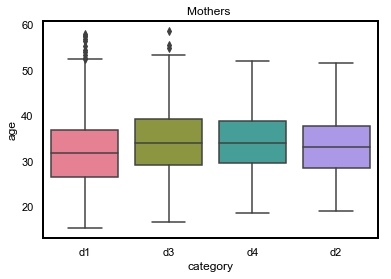

In [ ]:
sns.boxplot(x='category', y='age', palette='husl',
            data=df).set_title("Mothers ")

In [ ]:
pairplot_ready = df[est_cols[1:] + ['age']]

In [ ]:
sns.pairplot(pairplot_ready, hue="age")

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in l

In [39]:
est_cols

['intercept',
 'k_under2',
 'k_3to5',
 'education',
 'reg_ratio',
 'monthly_job_hours',
 'STATE_CC_COST',
 'STATE_MEDIAN_WAGE']

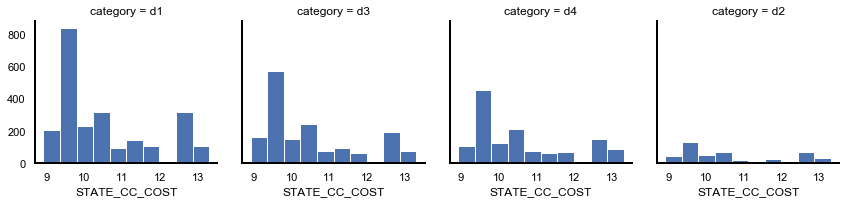

In [44]:
g = sns.FacetGrid(df, col='category')
g.map(plt.hist, 'STATE_CC_COST')

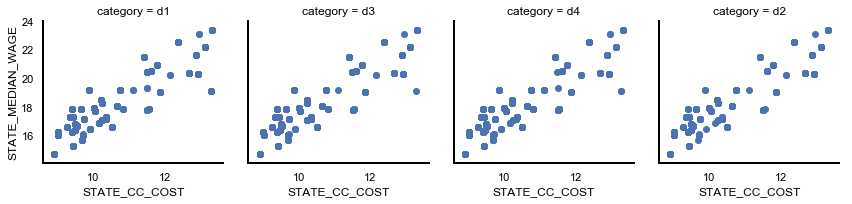

In [48]:
g = sns.FacetGrid(df, col='category')
g.map(plt.scatter, 'STATE_CC_COST', 'STATE_MEDIAN_WAGE')

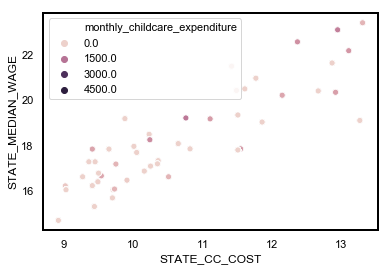

In [62]:
sns.scatterplot(x='STATE_CC_COST', y='STATE_MEDIAN_WAGE', data=df, hue='monthly_childcare_expenditure')

In [66]:
df.columns

Index(['Unnamed: 0', 'ssuid', 'monthly_childcare_expenditure', 'k_under2',
       'k_3to5', 'k_6to10', 'METRO', 'reg_ratio', 'criminal_records',
       'daycare_regulations', 'monthly_job_hrs', 'monthly_wage',
       'monthly_earned_income', 'monthly_unearned_income', 'education', 'age',
       'southern', 'State_number', 'log_expenditure', 'H', 'F', 'intercept',
       'monthly_job_hours', 'STATE', 'STATE_CC_COST', 'STATE_MEDIAN_WAGE',
       'd1', 'd2', 'd3', 'd4', 'category', 'has_kunder2', 'log_exp'],
      dtype='object')

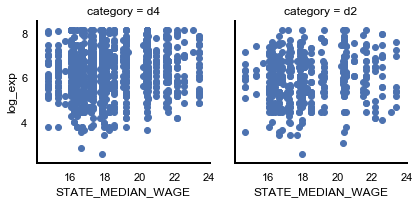

In [81]:
g = sns.FacetGrid(df[(df.category == 'd4') | (df.category == 'd2')], col='category')
g.map(plt.scatter, 'STATE_MEDIAN_WAGE', 'log_exp')

In [77]:
df[(df.category == 'd4') & (df.category == 'd2')]

,Unnamed: 0,ssuid,monthly_childcare_expenditure,k_under2,k_3to5,k_6to10,METRO,reg_ratio,criminal_records,daycare_regulations,...,STATE,STATE_CC_COST,STATE_MEDIAN_WAGE,d1,d2,d3,d4,category,has_kunder2,log_exp


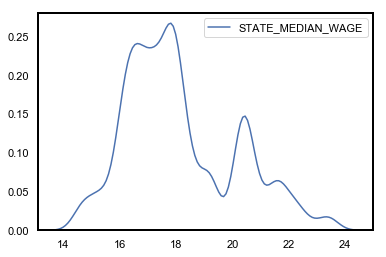

In [85]:
sns.kdeplot(df['STATE_MEDIAN_WAGE'])

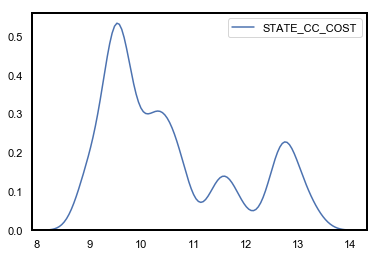

In [86]:
sns.kdeplot(df['STATE_CC_COST'])

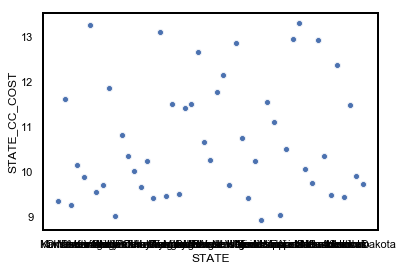

In [88]:
sns.barplot(x='STATE', y='STATE_CC_COST', data=df)

[Text(0, 0, 'Alabama'),
 Text(0, 0, 'Alaska'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'Arkansas'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Colorado'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'D.C.'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Hawaii'),
 Text(0, 0, 'Idaho'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Iowa'),
 Text(0, 0, 'Kansas'),
 Text(0, 0, 'Kentucky'),
 Text(0, 0, 'Louisiana'),
 Text(0, 0, 'Maine'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Minnesota'),
 Text(0, 0, 'Mississippi'),
 Text(0, 0, 'Missouri'),
 Text(0, 0, 'Montana'),
 Text(0, 0, 'Nebraska'),
 Text(0, 0, 'Nevada'),
 Text(0, 0, 'New Hampshire'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'New Mexico'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'North Datoka'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Oklahoma'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Rhode Is

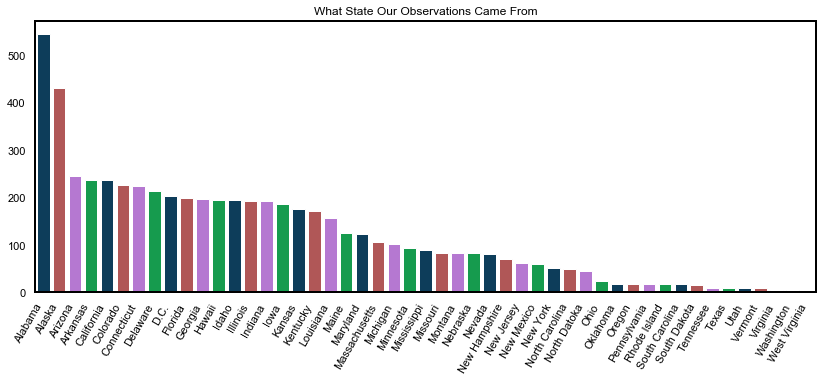

In [114]:
plt.figure(figsize=(14,5))
plt.title("What State Our Observations Came From")
sns.barplot(x=df.STATE.value_counts().index, y=df.STATE.value_counts().values, palette=dave_palette).set_xticklabels(
    chart.get_xticklabels(), rotation=60, ha='right')

In [155]:
median_wages = df.groupby("STATE")['STATE', 'STATE_MEDIAN_WAGE'].mean()
median_wages['STATE'] = median_wages.index
median_wages = median_wages.sort_values("STATE_MEDIAN_WAGE")

[Text(0, 0, 'Alabama'),
 Text(0, 0, 'Alaska'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'Arkansas'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Colorado'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'D.C.'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Hawaii'),
 Text(0, 0, 'Idaho'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Iowa'),
 Text(0, 0, 'Kansas'),
 Text(0, 0, 'Kentucky'),
 Text(0, 0, 'Louisiana'),
 Text(0, 0, 'Maine'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Minnesota'),
 Text(0, 0, 'Mississippi'),
 Text(0, 0, 'Missouri'),
 Text(0, 0, 'Montana'),
 Text(0, 0, 'Nebraska'),
 Text(0, 0, 'Nevada'),
 Text(0, 0, 'New Hampshire'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'New Mexico'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'North Datoka'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Oklahoma'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Rhode Is

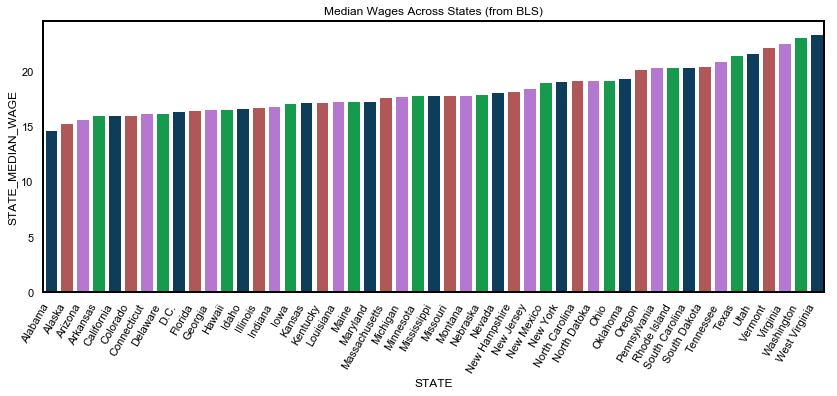

In [156]:
plt.figure(figsize=(14,5))
plt.title("Median Wages Across States (from BLS)")
sns.barplot(x='STATE', y='STATE_MEDIAN_WAGE', data=median_wages, palette=dave_palette).set_xticklabels(
    chart.get_xticklabels(), rotation=60, ha='right')

In [127]:
median_wages_ours = median_wages = df.groupby("STATE")['STATE', 'monthly_wage'].median()
median_wages['STATE'] = median_wages.index
median_wages = median_wages.sort_values("monthly_wage")

[Text(0, 0, 'Alabama'),
 Text(0, 0, 'Alaska'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'Arkansas'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Colorado'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'D.C.'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Hawaii'),
 Text(0, 0, 'Idaho'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Iowa'),
 Text(0, 0, 'Kansas'),
 Text(0, 0, 'Kentucky'),
 Text(0, 0, 'Louisiana'),
 Text(0, 0, 'Maine'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Minnesota'),
 Text(0, 0, 'Mississippi'),
 Text(0, 0, 'Missouri'),
 Text(0, 0, 'Montana'),
 Text(0, 0, 'Nebraska'),
 Text(0, 0, 'Nevada'),
 Text(0, 0, 'New Hampshire'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'New Mexico'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'North Datoka'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Oklahoma'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Rhode Is

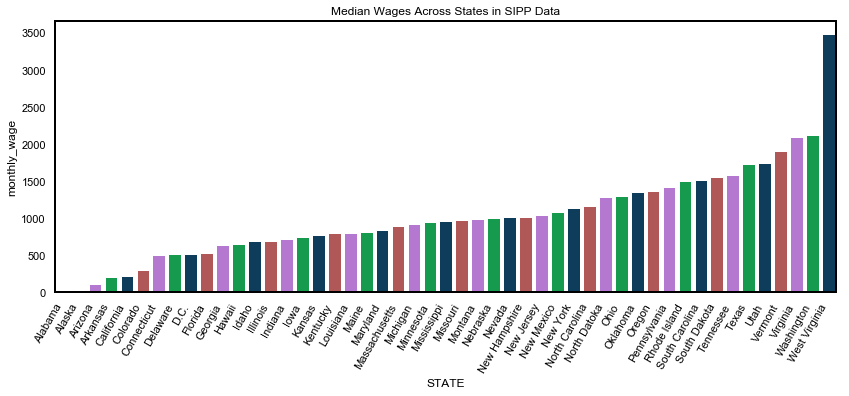

In [128]:
plt.figure(figsize=(14,5))
plt.title("Median Wages Across States in SIPP Data")
sns.barplot(x='STATE', y='monthly_wage', data=median_wages, palette=dave_palette).set_xticklabels(
    chart.get_xticklabels(), rotation=60, ha='right')

In [130]:
df.columns

Index(['Unnamed: 0', 'ssuid', 'monthly_childcare_expenditure', 'k_under2',
       'k_3to5', 'k_6to10', 'METRO', 'reg_ratio', 'criminal_records',
       'daycare_regulations', 'monthly_job_hrs', 'monthly_wage',
       'monthly_earned_income', 'monthly_unearned_income', 'education', 'age',
       'southern', 'State_number', 'log_expenditure', 'H', 'F', 'intercept',
       'monthly_job_hours', 'STATE', 'STATE_CC_COST', 'STATE_MEDIAN_WAGE',
       'd1', 'd2', 'd3', 'd4', 'category', 'has_kunder2', 'log_exp'],
      dtype='object')

In [152]:
median_ccc_ours = df[df.monthly_childcare_expenditure > .1]
median_ccc_ours = median_wages = median_ccc_ours.groupby("STATE")['STATE', 'monthly_childcare_expenditure'].median()
median_ccc_ours['STATE'] = median_ccc_ours.index
median_ccc_ours = median_ccc_ours.sort_values("monthly_childcare_expenditure")
median_ccc_ours.head()

,monthly_childcare_expenditure,STATE
STATE,,
Nevada,160.791429,Nevada
Kansas,291.162857,Kansas
Montana,304.200000,Montana
Utah,304.200000,Utah
Ohio,325.928571,Ohio


[Text(0, 0, 'Alabama'),
 Text(0, 0, 'Alaska'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'Arkansas'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Colorado'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'D.C.'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Hawaii'),
 Text(0, 0, 'Idaho'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Iowa'),
 Text(0, 0, 'Kansas'),
 Text(0, 0, 'Kentucky'),
 Text(0, 0, 'Louisiana'),
 Text(0, 0, 'Maine'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Minnesota'),
 Text(0, 0, 'Mississippi'),
 Text(0, 0, 'Missouri'),
 Text(0, 0, 'Montana'),
 Text(0, 0, 'Nebraska'),
 Text(0, 0, 'Nevada'),
 Text(0, 0, 'New Hampshire'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'New Mexico'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'North Datoka'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Oklahoma'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Rhode Is

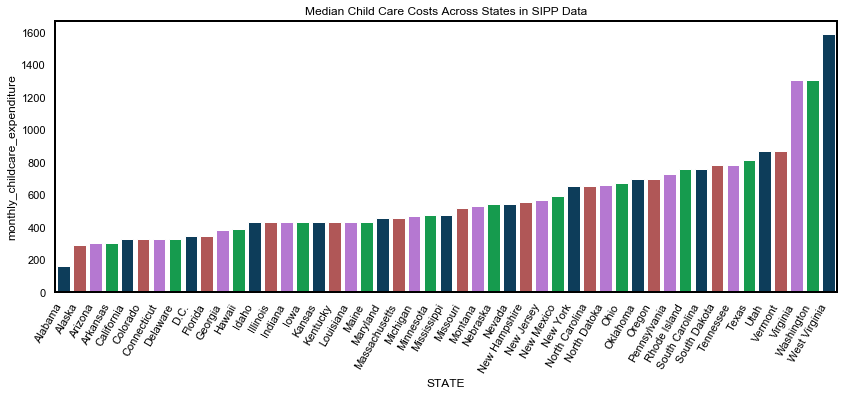

In [153]:
plt.figure(figsize=(14,5))
plt.title("Median Child Care Costs Across States in SIPP Data")
sns.barplot(x='STATE', y='monthly_childcare_expenditure', data=median_ccc_ours, palette=dave_palette).set_xticklabels(
    chart.get_xticklabels(), rotation=60, ha='right')

[Text(0, 0, 'Alabama'),
 Text(0, 0, 'Alaska'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'Arkansas'),
 Text(0, 0, 'California'),
 Text(0, 0, 'Colorado'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'D.C.'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Hawaii'),
 Text(0, 0, 'Idaho'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Iowa'),
 Text(0, 0, 'Kansas'),
 Text(0, 0, 'Kentucky'),
 Text(0, 0, 'Louisiana'),
 Text(0, 0, 'Maine'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Minnesota'),
 Text(0, 0, 'Mississippi'),
 Text(0, 0, 'Missouri'),
 Text(0, 0, 'Montana'),
 Text(0, 0, 'Nebraska'),
 Text(0, 0, 'Nevada'),
 Text(0, 0, 'New Hampshire'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'New Mexico'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'North Datoka'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Oklahoma'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Rhode Is

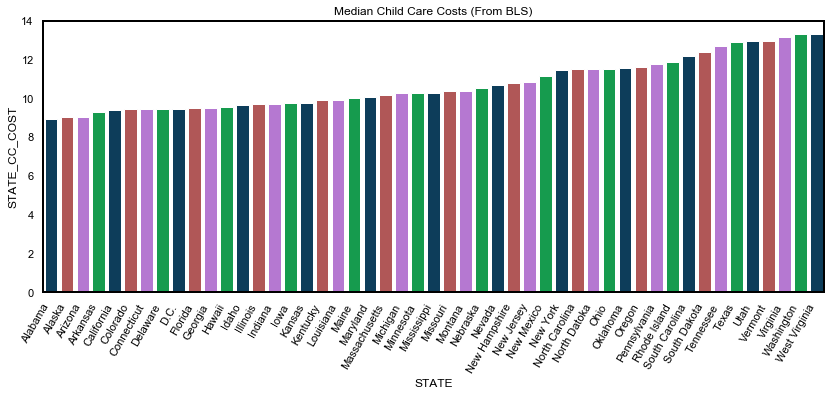

In [151]:
median_ccc = median_wages = df.groupby("STATE")['STATE', 'STATE_CC_COST'].median()
median_ccc['STATE'] = median_ccc.index
median_ccc = median_ccc.sort_values('STATE_CC_COST')

plt.figure(figsize=(14,5))
plt.title("Median Child Care Costs (From BLS)")
sns.barplot(x='STATE', y='STATE_CC_COST', data=median_ccc, palette=dave_palette).set_xticklabels(
    chart.get_xticklabels(), rotation=60, ha='right')

In [140]:
df.columns

Index(['Unnamed: 0', 'ssuid', 'monthly_childcare_expenditure', 'k_under2',
       'k_3to5', 'k_6to10', 'METRO', 'reg_ratio', 'criminal_records',
       'daycare_regulations', 'monthly_job_hrs', 'monthly_wage',
       'monthly_earned_income', 'monthly_unearned_income', 'education', 'age',
       'southern', 'State_number', 'log_expenditure', 'H', 'F', 'intercept',
       'monthly_job_hours', 'STATE', 'STATE_CC_COST', 'STATE_MEDIAN_WAGE',
       'd1', 'd2', 'd3', 'd4', 'category', 'has_kunder2', 'log_exp'],
      dtype='object')